In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import json
import codecs

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bb_intersection_over_union import bb_intersection_over_union

import random
import numpy as np
import PIL
from PIL import Image

from pandas.plotting import table
import time

import seaborn as sns

## Read data

In [2]:
# Path to Anno file from CelebA dataset
annotation_adress = 'D:\Datasety\CelabA\Anno'

# Path to img_celeba file from CelebA dataset
celebrity_pictures = 'D:\Datasety\CelabA\img_celeba\img_celeba.7z\img_celeba'

In [3]:
df_attributes = pd.read_csv(os.path.join(annotation_adress,'list_attr_celeba.csv'), delimiter=",", header=[0])

In [4]:
df_attributes.head(10)

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   
5  000006.jpg                -1                1           1               -1   
6  000007.jpg                 1               -1           1                1   
7  000008.jpg                 1                1          -1                1   
8  000009.jpg                -1                1           1               -1   
9  000010.jpg                -1               -1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   
5    -1     -1         1        -1          -1  ...         -1       -1   
6    -1     -1         1         1           1  ...         -1       -1   
7    -1     -1         1        -1           1  ...         -1       -1   
8    -1      1         1        -1          -1  ...         -1        1   
9    -1     -1        -1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   
5             -1          1                 1           -1                 1   
6              1         -1                -1           -1                -1   
7             -1         -1                -1           -1                -1   
8             -1         -1                 1           -1                 1   
9             -1          1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  
5                -1               -1      1  
6                -1               -1      1  
7                -1               -1      1  
8                -1               -1      1  
9                -1               -1      1  

[10 rows x 41 columns]

In [5]:
df_attributes[['image_id', 'Arched_Eyebrows', 'Wavy_Hair', 'Wearing_Hat']].head(10)

image_id  Arched_Eyebrows  Wavy_Hair  Wearing_Hat
0  000001.jpg                1         -1           -1
1  000002.jpg               -1         -1           -1
2  000003.jpg               -1          1           -1
3  000004.jpg               -1         -1           -1
4  000005.jpg                1         -1           -1
5  000006.jpg                1          1           -1
6  000007.jpg               -1         -1           -1
7  000008.jpg                1         -1           -1
8  000009.jpg                1         -1           -1
9  000010.jpg               -1          1           -1

### In evaluation status, "0" represents training image, "1" represents validation image, "2" represents testing image

In [6]:
df_eval = pd.read_csv(os.path.join(annotation_adress,'list_eval_partition.csv'), delimiter=",", header=[0])

In [7]:
df_eval.head(10)

image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0
5  000006.jpg          0
6  000007.jpg          0
7  000008.jpg          0
8  000009.jpg          0
9  000010.jpg          0

In [8]:
df_eval.partition.value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

### Bounding Boxes

In [30]:
df_boundingbox = pd.read_csv(os.path.join(annotation_adress,'list_bbox_celeba.csv'), delimiter=",", header=[0])

In [31]:
x_2 = df_boundingbox['x_1'] + df_boundingbox['width']
y_2 = df_boundingbox['y_1'] + df_boundingbox['height']
df_boundingbox['x_2'] = x_2
df_boundingbox['y_2'] = y_2
df_boundingbox.head(10)

image_id  x_1  y_1  width  height   x_2   y_2
0  000001.jpg   95   71    226     313   321   384
1  000002.jpg   72   94    221     306   293   400
2  000003.jpg  216   59     91     126   307   185
3  000004.jpg  622  257    564     781  1186  1038
4  000005.jpg  236  109    120     166   356   275
5  000006.jpg  146   67    182     252   328   319
6  000007.jpg   64   93    211     292   275   385
7  000008.jpg  212   89    218     302   430   391
8  000009.jpg  600  274    343     475   943   749
9  000010.jpg  113  110    211     292   324   402

In [32]:
#list of rectangles supported by opencv
list_of_gt = list(zip(df_boundingbox.x_1,df_boundingbox.y_1, df_boundingbox.x_2, df_boundingbox.y_2))

In [33]:
df_boundingbox.loc[[16]]

image_id  x_1  y_1  width  height  x_2  y_2
16  000017.jpg   40   64     62      86  102  150

## Data preparation

In [9]:
selected_random_10000 = random.sample(range(100000), 10000)

In [10]:
#D:\Datasety\CelabA\img_celeba\img_celeba.7z\img_celeba
def convert_to_grayscale(path, selected_pictures: list):
    '''Convert to grayscale selected photos
    path -> path to images from CelebA dataset
    selected pictures -> list of chosen pictures'''
    
    for filename in list(np.array(os.listdir(path))[selected_pictures]):
        #print(filename)
        #convert to grayscale + format change
        Image.open(os.path.join(path, filename)).convert('L').save(os.path.join(r'D:\Datasety\bmp_file_storage',filename))

In [18]:
#convert_to_grayscale(r'D:\Datasety\CelabA\img_celeba\img_celeba.7z\img_celeba', selected_random_10000)

In [19]:
selected_random_10000.sort() #sort list

In [11]:
#create train set

import os

def generate_train_set(bounding_box, path, filename_, filepath, selected_pictures):
    '''
     the function writes information about the rectangle drawn around the face to a txt file
     filepath / filename_ -> location of the info.txt file
     path -> location of selected jpg files from convert_to_grayscale
     the photos are ultimately SORTED in a folder, therefore the selected_pictures must be sorted
    '''
    filepath = os.path.join(filepath, filename_)
    x = list(np.array(df_boundingbox.x_1.tolist())[selected_pictures])
    y = list(np.array(df_boundingbox.y_1.tolist())[selected_pictures])
    w = list(np.array(df_boundingbox.width.tolist())[selected_pictures])
    h = list(np.array(df_boundingbox.height.tolist())[selected_pictures])
    with open(filepath, 'w') as f:
        i = 0
        for filename in os.listdir(path):
            name = 'rawdata/' + filename + ' ' + str(1) + ' ' + str(x[i]) + ' ' + str(y[i]) + ' ' + str(w[i]) + ' ' + str(h[i]) + '\n'
            i = i + 1 
            f.write(name)

In [22]:
#generate_train_set(df_boundingbox, path = r'D:\Datasety\bmp_file_storage', filename_ = 'info.txt', filepath = r'D:\Datasety', selected_pictures = selected_random_10000)

## One photo example

In [12]:
from collections import namedtuple
detection = namedtuple("detection", ["image_path", "gt", "pred"])

In [13]:
cascPath = r'C:\Users\FilSo\PycharmProjects\Master Thesis'
classyfier = 'cascade_3090p_3019n_15stages.xml'
cascPath = os.path.join(cascPath, classyfier)
faceCascade = cv2.CascadeClassifier(cascPath)

In [14]:
imagePath = os.path.join(celebrity_pictures, '000001.jpg')
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [15]:
scale_value = 1.05
neig = 20
faces = faceCascade.detectMultiScale(gray, scale_value, neig)
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    a = detection('000001.jpg', [95, 71, 321, 384], [x,y,x+w,y+h])

In [16]:
cv2.rectangle(image, (95, 71), (321, 384), (0, 0, 255), 2)
cv2.imshow("Faces found", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
iou = bb_intersection_over_union(a.gt, a.pred)
iou

0.732826983871832

## Multiple cases evaluation

In [17]:
def get_images_size(list_of_files):
    '''dedicated function to read size of all images
    reason behind creating dedicated tool is to avoid calculation time mistakes'''
    img_size = []
    for filename in list_of_files:
        imagePath = os.path.join(celebrity_pictures, filename)
        image = cv2.imread(imagePath)
        image_size = image.shape
        image_size = image.shape[0] * image.shape[1]
        img_size.append(image_size)
    return img_size     

In [18]:
cascPath = r'C:\Users\FilSo\PycharmProjects\Master Thesis'
classyfier = 'cascade_3090p_3019n_15stages.xml'
#classyfier = 'cascade_920p_3019n_ckplus_corrected.xml'
build_classyfier = 'haarcascade_frontalface_default.xml'

usercascPath = os.path.join(cascPath, classyfier)
faceCascade = cv2.CascadeClassifier(usercascPath)

buildPath = os.path.join(cascPath, build_classyfier)
buildCascade = cv2.CascadeClassifier(buildPath)

def prediction_faces(iteration_list, scale_val = 1.05, n = 8, cascade = faceCascade):
    '''function returs image names and predicted rectangle region, also the time list of each calculation'''
    list_of_pred = []
    list_of_files = []
    time_list = []
    #iteration_num = iteration
    scale_value = scale_val
    neig = n
    img_size = []

    for filename in list(np.array(os.listdir(celebrity_pictures))[iteration_list]):
        coordinates_of_one_face = []
        list_of_files.append(filename)

        imagePath = os.path.join(celebrity_pictures, filename)
        start = time.time()
        image = cv2.imread(imagePath)
        #image_size = image.shape 
        #image_size = image.shape[0] * image.shape[1]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #img_size.append(image_size)
        faces = cascade.detectMultiScale(gray, scale_value, neig)
        for (x, y, w, h) in faces:
            coordinates_of_one_face.append([x,y,x+w,y+h])
        end = time.time()
        time_list.append(end-start)
        list_of_pred.append(coordinates_of_one_face)
    return list_of_pred, list_of_files, time_list

In [172]:
iteration_list = random.sample(range(100000,200000), 10000) 
iteration_list.sort()

In [20]:
#read list from .txt file to use the same one for comparison purposes
iteration_list = []

# open file and read the content in a list
with open('iteration_list.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        iteration_list.append(int(currentPlace))

In [21]:
basic_cascade = cv2.CascadeClassifier(os.path.join(cascPath,'cascade_3090p_3019n_15stages_BASIC.xml'))
list_of_pred_BASIC, list_of_files_BASIC, calculation_time_BASIC = prediction_faces(iteration_list, cascade = basic_cascade)

In [22]:
huge_cascade = cv2.CascadeClassifier(os.path.join(cascPath,'haar_cascade_all_9000p_4500n.xml'))
list_of_pred_huge, list_of_files_huge, calculation_time_huge = prediction_faces(iteration_list, cascade = huge_cascade)

In [23]:
image_size_huge = get_images_size(list_of_files_huge)

In [24]:
def test_alpha(alpha_list, cascade, iteration):
    time_per_alpha = []
    num_pos = []
    for alpha in alpha_list:
        print(alpha)
        list_of_p, list_of_f, calc_time = prediction_faces(iteration, scale_val = alpha, cascade=cascade)
        image_sizeee = get_images_size(list_of_f)
        df_t = create_dataframe(list_of_p, list_of_f, iteration, list_of_gt,calc_time, image_sizeee)
        af = np.mean(df_t[df_t.IoU.between(0.35,1)]['Calculation time'])
        time_per_alpha.append(af)
        num_pos.append(df_t[df_t.IoU.between(0.35,1)].shape[0])
    return time_per_alpha, num_pos

In [25]:
def test_neib(neib_list, cascade, iteration):
    time_per_neib = []
    num_pos_neib = []
    false_pos_nei = []
    false_negatives_neib = []
    for neib in neib_list:
        print(neib)
        list_of_p, list_of_f, calc_time = prediction_faces(iteration, n = neib, cascade=cascade)
        image_sizeee = get_images_size(list_of_f)
        df_t = create_dataframe(list_of_p, list_of_f, iteration, list_of_gt,calc_time, image_sizeee)
        af = np.mean(df_t[df_t.IoU.between(0.35,1)]['Calculation time'])
        time_per_neib.append(af)
        num_pos_neib.append(df_t[df_t.IoU.between(0.35,1)].shape[0])
        false_pos_nei.append(df_t[df_t.IoU == 500].shape[0])
        false_negatives_neib.append(df_t[df_t.IoU == 1000].shape[0])
    return time_per_neib, num_pos_neib, false_pos_nei, false_negatives_neib

In [34]:
def create_dataframe(list_of_pred, list_of_files, iteration_num, list_of_gt, list_of_calc_time, image_size_list):
    '''create dataframe from predictions, files, also compute iou value'''
    data = {'Image':list_of_files,'Real':list(np.array(list_of_gt)[iteration_num]), 'Predictions':list_of_pred, 
            'Calculation time':list_of_calc_time, 'Image size': image_size_list}
    df_comparision = pd.DataFrame(data)
    rows, cols = df_comparision.shape
    iou_list = []
    num_predictions = []
    for index, row in df_comparision.iterrows():
        if len(row['Predictions']) == 0:
            iou_list.append(1000)
            num_predictions.append(0)
        elif len(row['Predictions']) > 1:
            iou_list.append(500)
            num_predictions.append(len(row['Predictions']))
        else:
            iou = bb_intersection_over_union(row['Real'], row['Predictions'][0]) #predictions[0] bo zwraca liste w liście
            iou_list.append(iou)
            num_predictions.append(1)
    df_comparision['IoU'] = iou_list
    df_comparision['Num predictions'] = num_predictions
    return df_comparision

In [57]:
def get_threshold(dataframe, threshold):
    df_mask = dataframe.IoU <=threshold
    selected_df = dataframe[df_mask]
    return selected_df

In [35]:
#t_alpha = [1.02,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]
#time_per_alpha, num_pos = test_alpha(alpha_list = t_alpha, cascade = faceCascade, iteration = iteration_list[:300])

In [36]:
t_neib = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
time_per_nei, num_pos_nei, false_pos_neib, false_negatives_neib = test_neib(neib_list = t_neib, cascade = faceCascade, iteration = iteration_list[:300])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [38]:
sns.set()

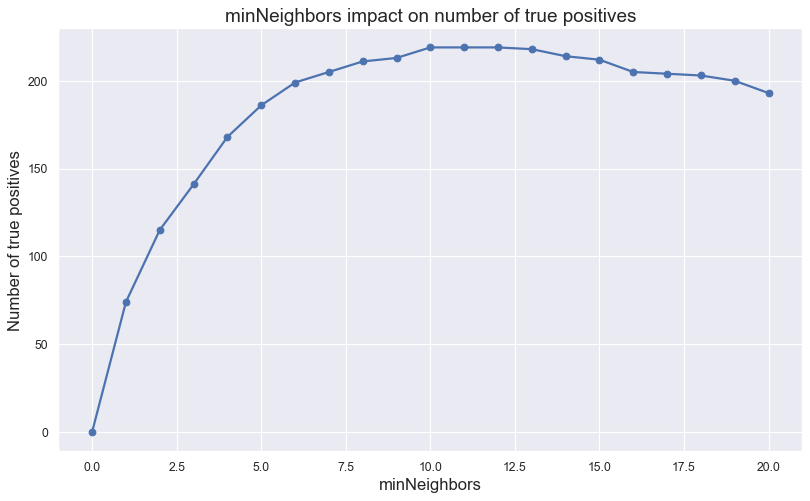

In [49]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(t_neib,num_pos_nei, lw=2, marker = 'o')
plt.xlabel('minNeighbors', fontsize = 15)
plt.ylabel('Number of true positives', fontsize = 15)
plt.title('minNeighbors impact on number of true positives', fontsize = 17)
plt.show() 

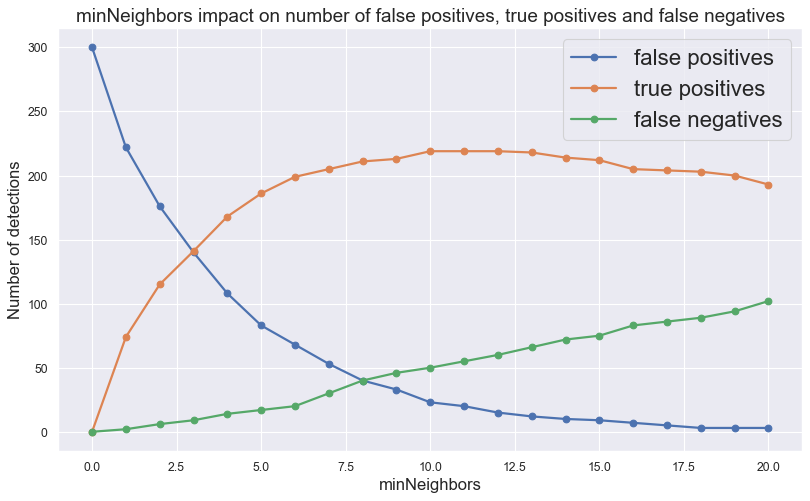

In [48]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(t_neib,false_pos_neib, lw=2, marker = 'o',label = 'false positives')
plt.plot(t_neib,num_pos_nei, lw=2, marker = 'o', label = 'true positives')
plt.plot(t_neib,false_negatives_neib, lw=2, marker = 'o', label = 'false negatives')
plt.xlabel('minNeighbors', fontsize = 15)
plt.ylabel('Number of detections', fontsize = 15)
plt.title('minNeighbors impact on number of false positives, true positives and false negatives', fontsize = 17)
plt.legend(loc="best",  prop={'size': 20})
plt.show() 

In [42]:
image_size_BASIC = get_images_size(list_of_files_BASIC) #usually image size will be, for each classifier,
                                                        #the same due to comparision

In [50]:
np.mean(calculation_time_BASIC)

0.05623965227603912

In [51]:
list_of_pred, list_of_files, calculation_time = prediction_faces(iteration_list)

In [52]:
image_size = get_images_size(list_of_files)

In [402]:
np.mean(calculation_time)

In [218]:
list_of_pred_build, list_of_files_build, calculation_time_build = prediction_faces(iteration_list, cascade = buildCascade)

In [54]:
#np.mean(calculation_time_build)

In [56]:
#image_size_build = get_images_size(list_of_files_build)

In [58]:
df_comparision = create_dataframe(list_of_pred, list_of_files, iteration_list, list_of_gt, calculation_time, image_size)
#df_comparision_build = create_dataframe(list_of_pred_build, list_of_files_build, iteration_list, list_of_gt, calculation_time_build, image_size_build)
df_comparision_basic = create_dataframe(list_of_pred_BASIC, list_of_files_BASIC, iteration_list, list_of_gt, calculation_time_BASIC, image_size_BASIC)

In [59]:
df_comparision_huge = create_dataframe(list_of_pred_huge, list_of_files_huge, iteration_list, list_of_gt, calculation_time_huge, image_size_huge)

In [60]:
df_comparision.head()

Image                  Real  \
0  010009.jpg    [59, 56, 348, 456]   
1  010018.jpg  [534, 216, 721, 475]   
2  010022.jpg    [67, 50, 324, 406]   
3  010023.jpg    [66, 46, 175, 197]   
4  010029.jpg   [159, 38, 307, 243]   

                                  Predictions  Calculation time  Image size  \
0                        [[35, 77, 388, 430]]          0.038868      220500   
1                      [[507, 217, 760, 470]]          0.079787      786432   
2                        [[69, 81, 337, 349]]          0.026480      183000   
3      [[22, 32, 82, 92], [63, 59, 178, 174]]          0.015957       75576   
4  [[181, 42, 245, 106], [136, 40, 341, 245]]          0.048869      255600   

          IoU  Num predictions  
0    0.738848                1  
1    0.727439                1  
2    0.720312                1  
3  500.000000                2  
4  500.000000                2

In [62]:
y_axis_labels = ['Calculation time', 'Image size', 'Num predictions']

Text(0.5, 1.0, 'Correlation matrix for EXTENDED classifier')

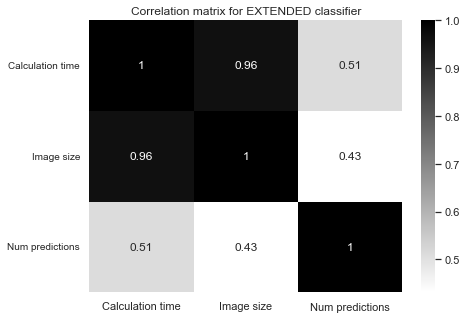

In [63]:
corr_select = df_comparision[['Calculation time', 'Image size', 'Num predictions']]
corr = corr_select.corr()
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.heatmap(corr, annot = True,
        yticklabels=y_axis_labels, 
           cmap='binary')
plt.yticks(np.arange(3)+0.5,('Calculation time', 'Image size', 'Num predictions'),
           rotation=0, fontsize="10", va="center")
ax.set_title('Correlation matrix for EXTENDED classifier')

Text(0.5, 1.0, 'Correlation matrix for BASIC classifier')

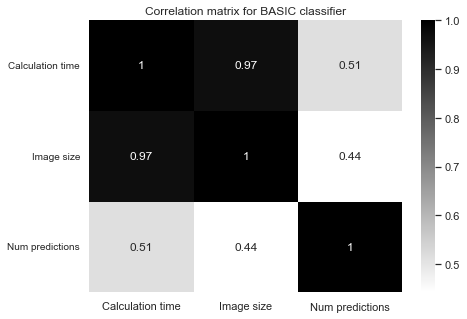

In [64]:
corr_select = df_comparision_basic[['Calculation time', 'Image size', 'Num predictions']]
corr = corr_select.corr()
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.heatmap(corr, annot = True,
        yticklabels=y_axis_labels, 
           cmap='binary')
plt.yticks(np.arange(3)+0.5,('Calculation time', 'Image size', 'Num predictions'),
           rotation=0, fontsize="10", va="center")
ax.set_title('Correlation matrix for BASIC classifier')

In [62]:
#from sklearn.preprocessing import MinMaxScaler

In [63]:
#scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [65]:
#false positives
false_positives = df_comparision[df_comparision.IoU == 500].shape[0]
false_positives

1566

In [66]:
#np.mean(df_comparision[df_comparision.IoU == 1000]['Calculation time'])

In [67]:
#false positives for build classifier
false_positives_basic = df_comparision_basic[df_comparision_basic.IoU == 500].shape[0]
false_positives_basic

1481

In [68]:
#np.mean(df_comparision_basic[df_comparision_basic.IoU == 1000]['Calculation time'])

In [69]:
df_with_false_positives = df_comparision[df_comparision.IoU == 500]

In [70]:
#false negatives
false_negatives = df_comparision[df_comparision.IoU == 1000].shape[0]
false_negatives

1332

In [71]:
false_negatives_basic = df_comparision_basic[df_comparision_basic.IoU == 1000].shape[0]
false_negatives_basic

1434

In [72]:
df_with_false_negatives = df_comparision[df_comparision.IoU == 1000]

In [73]:
df_with_true_positives = get_threshold(df_comparision, 1)

In [74]:
df_with_true_positives

Image                  Real             Predictions  \
0     010009.jpg    [59, 56, 348, 456]    [[35, 77, 388, 430]]   
1     010018.jpg  [534, 216, 721, 475]  [[507, 217, 760, 470]]   
2     010022.jpg    [67, 50, 324, 406]    [[69, 81, 337, 349]]   
5     010031.jpg    [83, 88, 309, 401]    [[65, 94, 347, 376]]   
7     010038.jpg    [19, 42, 188, 267]    [[15, 62, 195, 242]]   
...          ...                   ...                     ...   
9992  099958.jpg    [99, 41, 216, 203]    [[88, 48, 233, 193]]   
9994  099982.jpg   [110, 17, 245, 204]   [[119, 46, 234, 161]]   
9995  099987.jpg    [22, 51, 233, 312]    [[36, 87, 213, 264]]   
9996  099989.jpg    [33, 44, 166, 228]    [[32, 60, 163, 191]]   
9997  099991.jpg   [233, 48, 407, 289]   [[221, 63, 435, 277]]   

      Calculation time  Image size       IoU  Num predictions  
0             0.038868      220500  0.738848                1  
1             0.079787      786432  0.727439                1  
2             0.026480      183000  0.720312                1  
5             0.021941      191115  0.737334                1  
7             0.015957       60525  0.761426                1  
...                ...         ...       ...              ...  
9992          0.031914      187500  0.738702                1  
9994          0.021940      180500  0.526283                1  
9995          0.014960       92610  0.570431                1  
9996          0.014960       73248  0.693845                1  
9997          0.038896      177500  0.738469                1  

[7102 rows x 7 columns]

In [75]:
np.mean(df_with_true_positives['Calculation time'].tolist())

0.05122586295021248

In [77]:
#np.mean(df_with_true_positives_basic['Calculation time'].tolist())

In [78]:
def hist_for_work_plot(dataframe, title):
    hist_plot = dataframe[dataframe['IoU'].between(0.35,1)].IoU.hist(alpha=0.5, bins=30, log = True, color = 'red', figsize=(7,5))
    hist_plot.set_title(title)
    hist_plot.set_xlabel('IoU')
    hist_plot.set_ylabel('Number of images')
    return dataframe[dataframe['IoU'].between(0.35,1)].IoU.describe()

In [79]:
#from sklearn import preprocessing
#df_with_true_positives_tttt = df_with_true_positives.copy()
#x = df_with_true_positives_tttt['Image size'].values.reshape(-1, 1) #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df_with_true_positives_tttt['Image size scaled'] = x_scaled

In [80]:
#df_with_true_positives_tttt

## Visualizations

count    6770.000000
mean        0.712407
std         0.059588
min         0.350480
25%         0.717672
50%         0.735791
75%         0.739160
max         0.883235
Name: IoU, dtype: float64

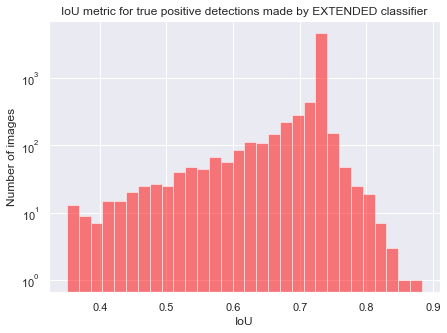

In [87]:
hist_for_work_plot(df_with_true_positives, 'IoU metric for true positive detections made by EXTENDED classifier')

In [88]:
df_with_true_positives_basic = get_threshold(df_comparision_basic,1)

count    6734.000000
mean        0.715980
std         0.054941
min         0.352335
25%         0.724639
50%         0.736238
75%         0.739240
max         0.850014
Name: IoU, dtype: float64

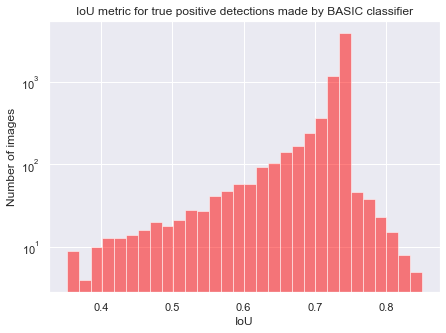

In [89]:
hist_for_work_plot(df_with_true_positives_basic, 'IoU metric for true positive detections made by BASIC classifier')

In [90]:
def plot_histogram_with_table(data):
    fig, ax = plt.subplots(1,1)
    table(ax, np.round(data.IoU.describe(), 2), loc="best", colWidths=[0.05])
    hist_plot = data.IoU.hist(ax = ax,bins = 50 , log = True, color = 'red',  figsize=(16,10))
    hist_plot.set_title('IOU metric')
    hist_plot.set_xlabel('IOU')
    hist_plot.set_ylabel('Number of images')  

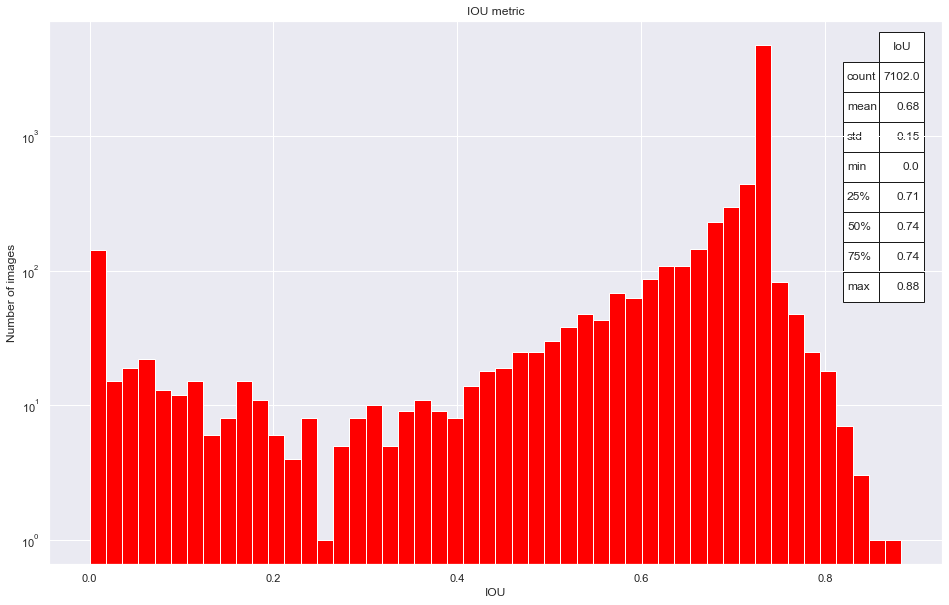

In [91]:
plot_histogram_with_table(df_with_true_positives)

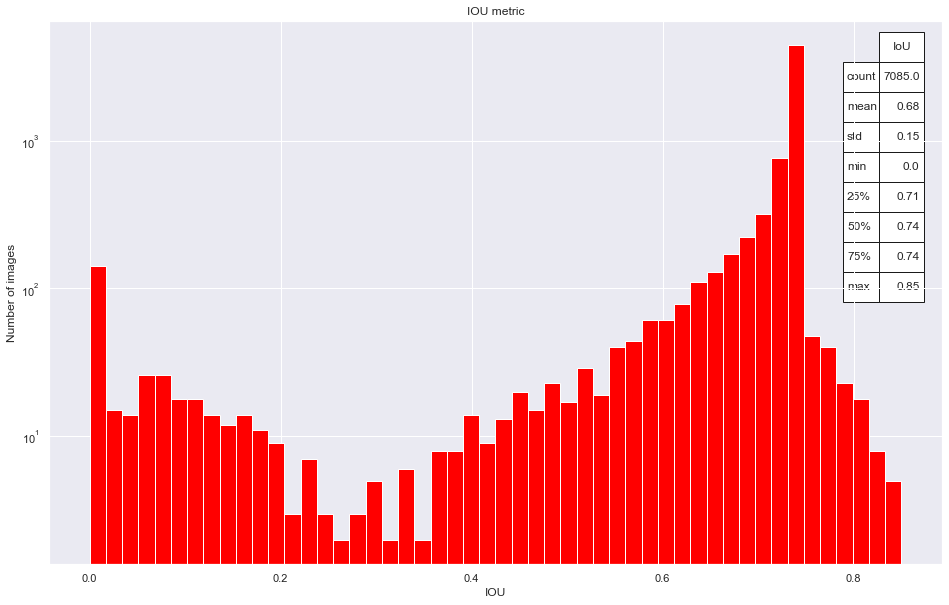

In [92]:
plot_histogram_with_table(df_with_true_positives_basic)

### Negative image example

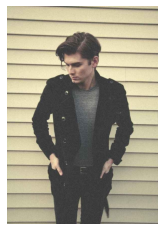

In [93]:
img = df_with_false_negatives.Image.tolist()[2]
imagePath = os.path.join(celebrity_pictures, img)
image = cv2.imread(imagePath)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #normally openCV use BGR format 
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Functions created for visualization purposes

In [94]:
def resize_image_set(list_im: list, shape = None):
    '''function return hstack resized images for plotting purposes'''
    imgs    = [PIL.Image.open(i) for i in list_im]
    if shape:
        min_shape = shape
    else:
        min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray(i.resize(min_shape)) for i in imgs))
    return imgs_comb

In [95]:
def plot_images_side_by_side(image_list: list, shape = (400,400), row_length = 4):
    
    rows = 2
    columns = 1
    first_row = resize_image_set(image_list[:row_length], shape)
    second_row = resize_image_set(image_list[row_length:], shape)
    fig = plt.figure(figsize=(15, 7))
    fig.subplots_adjust(hspace=0.0)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(first_row)
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(second_row)
    plt.axis('off')

In [96]:
#false_positives_image_directory = r'C:\Users\FilSo\PycharmProjects\Master Thesis\false_positives'
false_positives_image_directory = r'D:\df_false_positives'

def images_marked_as_false_positive(dataFrame, directory = false_positives_image_directory, shape = (400,400)):
    list_of_integers = [i for i in range(dataFrame.shape[0])]
    list_im = []
    for position in list_of_integers:
        img_name = dataFrame.Image.tolist()[position]
        img_path = os.path.join(celebrity_pictures, img_name)
        mark_details = dataFrame.Predictions.tolist()[position]
        image = cv2.imread(img_path)
        for prediction in mark_details:
            cv2.rectangle(image, (prediction[0], prediction[1]), (prediction[2], prediction[3]), (0, 255, 0), 5)
        iou = dataFrame.IoU.tolist()[position]

        #resize images for given shape
        down_points = shape
        image = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
        cv2.rectangle(image, (10,10), (10 + 150, 30 + 10), (0,0,0), -1)
        cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        false_postive_with_rectangle_dir = directory + '\Image' + str(position) + '.jpg'
        cv2.imwrite(false_postive_with_rectangle_dir, image)
        list_im.append(false_postive_with_rectangle_dir)
    return list_im

### IOU discussion

In [97]:
list_im = images_marked_as_false_positive(df_with_false_positives)

In [98]:
df_with_false_positives.shape[0]

1566

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


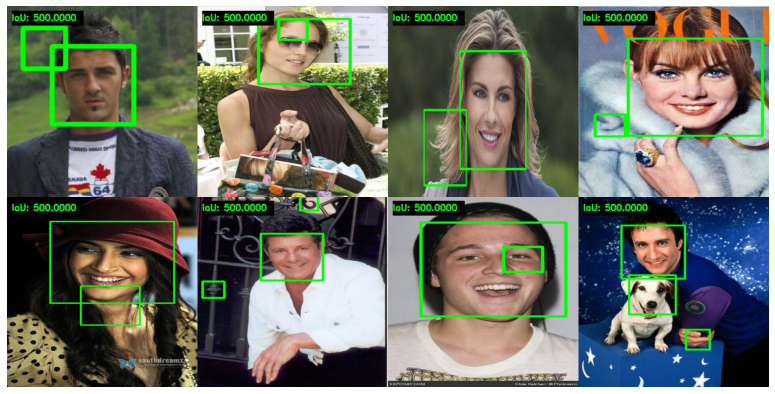

In [99]:
plot_images_side_by_side(list(np.array(list_im)[[0,1,24,5,11,43,46, 141]]))

In [100]:
false_negatives_image_directory = r'D:\df_false_negatives'

In [101]:
df_with_1000_iou = df_comparision[df_comparision.IoU == 1000]

In [102]:
list_im_negatives = images_marked_as_false_positive(df_with_1000_iou, false_negatives_image_directory)

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


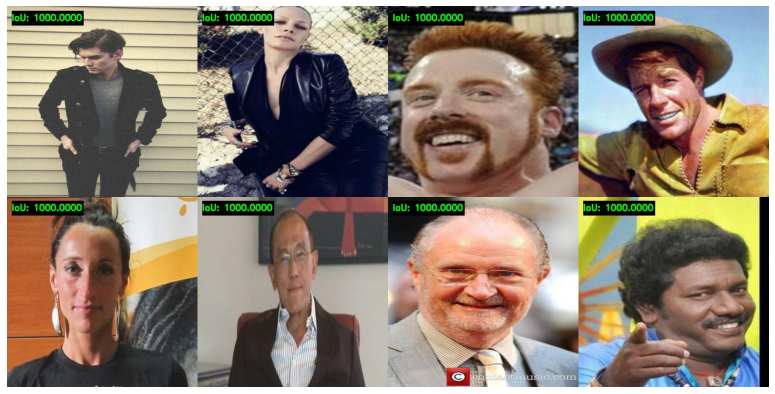

In [103]:
plot_images_side_by_side(list(np.array(list_im_negatives)[[2,3,6,7,9,11,52,116]]))

In [138]:
true_false_positives_image_directory = r'D:\df_with_true_false_positives_0'

In [139]:
df_with_0_iou = df_comparision[df_comparision.IoU == 0.0]

In [140]:
df_with_0_iou.shape[0]

121

In [141]:
list_im_0 = images_marked_as_false_positive(df_with_0_iou, true_false_positives_image_directory)

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


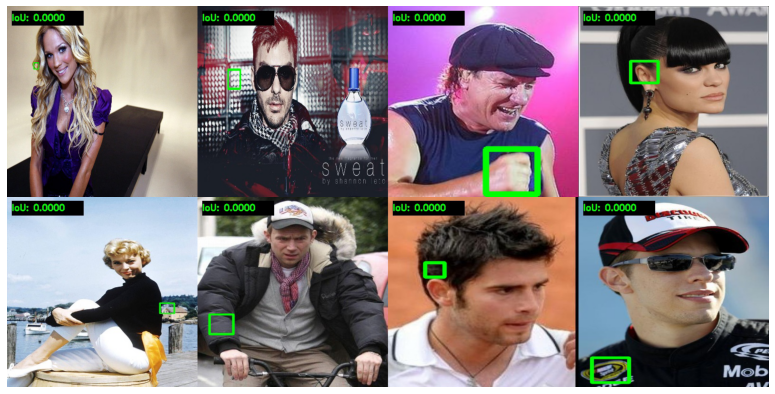

In [148]:
plot_images_side_by_side(list(np.array(list_im_0)[[2,3,6,7,9,11,52,116]]))

In [150]:
true_false_positives_image_directory_01_02 = r'D:\df_with_true_false_positives_01_02'
true_false_positives_image_directory_02_03 = r'D:\df_with_true_false_positives_02_03'
true_false_positives_image_directory_03_035 = r'D:\df_with_true_false_positives_03_035'
true_false_positives_image_directory_035_04 = r'D:\df_with_true_false_positives_035_04'

In [144]:
df_with_01_and_03_iou = df_comparision[df_comparision.IoU.between(0.1,0.2)]
list_im_01_02 = images_marked_as_false_positive(df_with_01_and_03_iou, true_false_positives_image_directory_01_02)

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


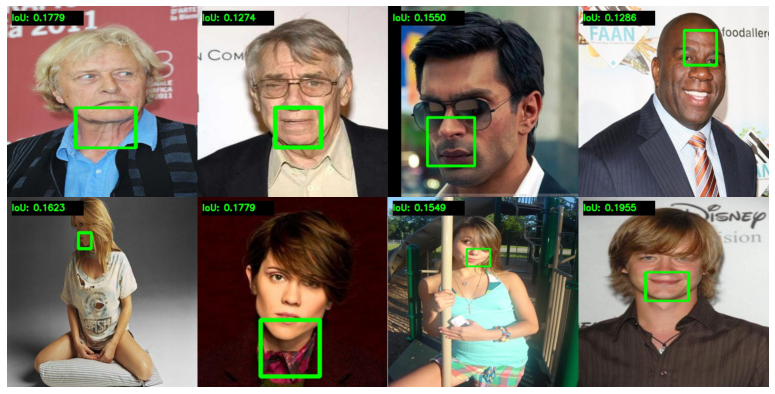

In [149]:
plot_images_side_by_side(list(np.array(list_im_01_02)[[0,1,2,51,4,5,6,7]]))

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


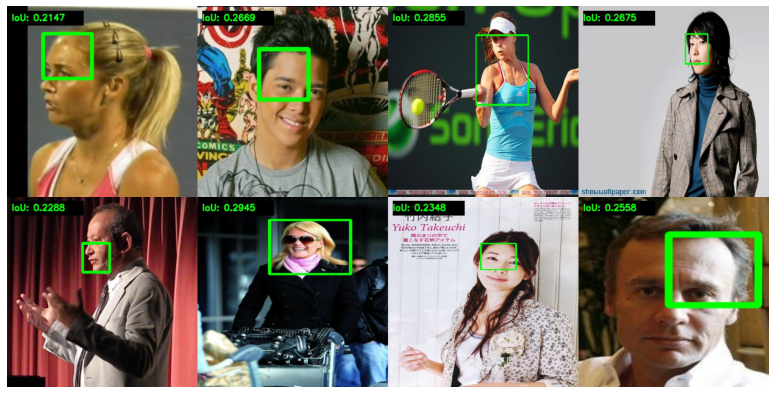

In [146]:
df_with_03_and_05_iou = df_comparision[df_comparision.IoU.between(0.2,0.3)]
list_im_03_035 = images_marked_as_false_positive(df_with_03_and_05_iou, true_false_positives_image_directory_02_03)
plot_images_side_by_side(list(np.array(list_im_03_035)[[i for i in range(8)]]))

In [152]:
df_with_03_and_05_iou = df_comparision[df_comparision.IoU.between(0.3,0.35)]
list_im_03_035_real = images_marked_as_false_positive(df_with_03_and_05_iou, true_false_positives_image_directory_03_035)

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


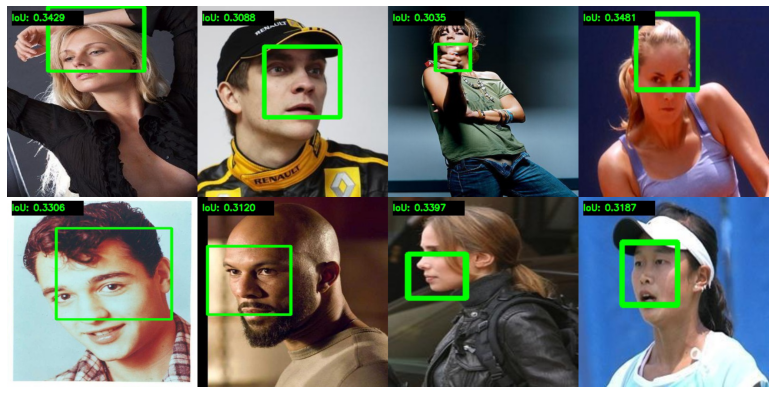

In [153]:
plot_images_side_by_side(list(np.array(list_im_03_035_real)[[0,1,11,3,4,5,6,7]]))

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


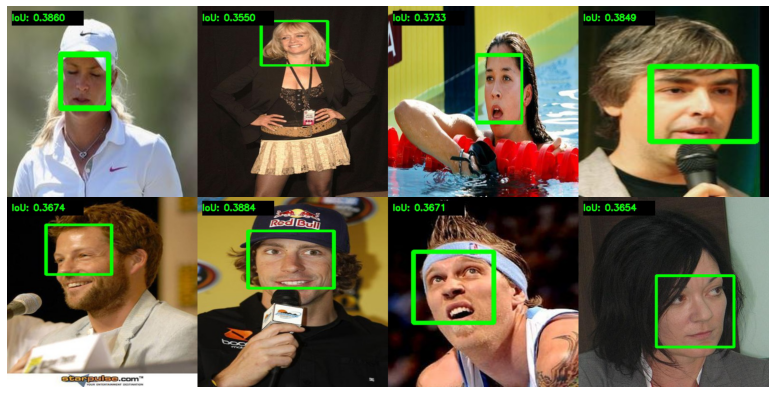

In [151]:
df_with_035_and_04_iou = df_comparision[df_comparision.IoU.between(0.35,0.4)]
list_im_035_04 = images_marked_as_false_positive(df_with_035_and_04_iou, true_false_positives_image_directory_035_04)
plot_images_side_by_side(list(np.array(list_im_035_04)[[i for i in range(8)]]))

## Evaluation

In [154]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [156]:
#mark as true positives but in fact false positives
df_with_true_positives[df_with_true_positives.IoU.between(0,0.35)].shape

(332, 7)

In [104]:
def evaluate_results(dataframe):
    '''function returns TP, TN, FP, FN'''
    # get true positives
    df_with_true_positives = get_threshold(dataframe, 1)
    #mark as true positives but in fact false positives
    actual_false_positives = df_with_true_positives[df_with_true_positives.IoU.between(0,0.35)].shape[0]
    true_pos_val = df_with_true_positives.shape[0] - actual_false_positives
    false_positives = dataframe[dataframe.IoU == 500].shape[0]
    false_pos_val = false_positives + actual_false_positives
    false_neg = dataframe[dataframe.IoU == 1000].shape[0]
    return true_pos_val, 0, false_pos_val, false_neg

In [105]:
def get_calc_time(dataframe):
    '''function returns calculation time'''
    # get true positives
    df_with_true_positives = get_threshold(dataframe, 1)
    #mark as true positives but in fact false positives
    #actual_false_positives = df_with_true_positives[df_with_true_positives.IoU.between(0,0.35)].shape[0]
    return np.mean(df_with_true_positives['Calculation time'].tolist()), np.mean(dataframe['Calculation time'].tolist())

In [274]:
evaluate_results(df_comparision)

(6770, 0, 1898, 1332)

In [275]:
evaluate_results(df_comparision_basic)

(6734, 0, 1832, 1434)

In [179]:
evaluate_results(df_comparision_huge)

(6307, 0, 3168, 525)

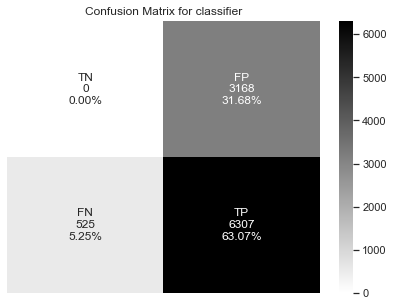

In [183]:
plot_confusion_matrix(evaluate_results(df_comparision_huge), 'Confusion Matrix for classifier')

In [184]:
get_calc_time(df_comparision_huge)

(0.052827143336888045, 0.07521717231273652)

In [110]:
get_calc_time(df_comparision_huge[df_comparision_huge.IoU.between(0.35,1)])

(0.04700810348968259, 0.04700810348968259)

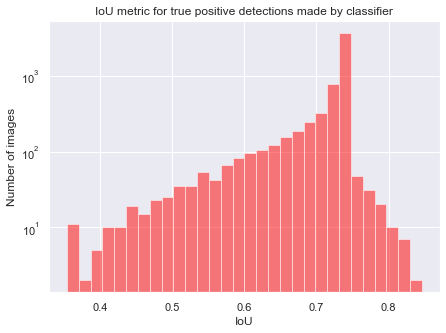

In [190]:
hist_for_work_plot(df_comparision_huge, 'IoU metric for true positive detections made by classifier')

In [66]:
def calc_metric(data: tuple):
    true_pos_val, true_neg, false_pos_val, false_neg = data
    precision = true_pos_val / (true_pos_val + false_pos_val)
    recall = true_pos_val / (true_pos_val + false_neg)
    return recall, precision

In [277]:
calc_metric(evaluate_results(df_comparision))

(0.8355961490989879, 0.7810336871250577)

In [278]:
calc_metric(evaluate_results(df_comparision_basic))

(0.8244368266405485, 0.7861312164370768)

In [182]:
def plot_confusion_matrix(params: tuple, title):
    TP, TN, FP, FN = params
    cf_matrix = np.array([[TN, FP], [FN, TP]])
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(7,5)) 
    ax.set_title(title)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='binary', xticklabels = False, yticklabels = False, ax = ax)

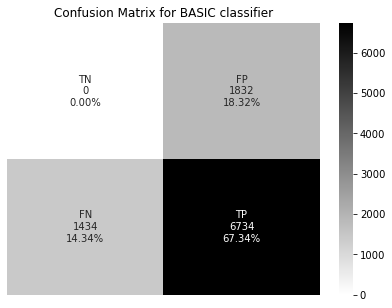

In [166]:
plot_confusion_matrix(evaluate_results(df_comparision_basic), 'Confusion Matrix for BASIC classifier')

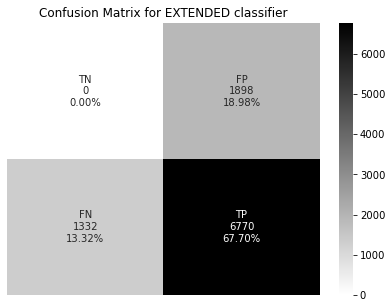

In [167]:
plot_confusion_matrix(evaluate_results(df_comparision), 'Confusion Matrix for EXTENDED classifier')

## Different stage number consideration

In [51]:
considered_set = iteration_list[:100]

In [52]:
cascade_5stages = cv2.CascadeClassifier(os.path.join(cascPath,'haar_cascade_all_5stages_2950_3019.xml'))
list_of_pred_5stages, list_of_files_5stages, calculation_time_5stages = prediction_faces(iteration_list = considered_set, cascade = cascade_5stages)

In [58]:
image_size_5stages = get_images_size(list_of_files_5stages)

In [54]:
df_comparision_5stages = create_dataframe(list_of_pred_5stages, list_of_files_5stages, 
                                          iteration_list[:100], list_of_gt, calculation_time_5stages, image_size_5stages)

In [48]:
cascade_10stages = cv2.CascadeClassifier(os.path.join(cascPath,'haar_cascade_all_10stages_2950_3019.xml'))
list_of_pred_10stages, list_of_files_10stages, calculation_time_10stages = prediction_faces(considered_set, cascade = cascade_10stages)

In [57]:
image_size_10stages = get_images_size(list_of_files_10stages)

In [59]:
df_comparision_10stages = create_dataframe(list_of_pred_10stages, list_of_files_10stages, 
                                          iteration_list[:1000], list_of_gt, calculation_time_10stages, image_size_10stages)

In [49]:
cascade_15stages = cv2.CascadeClassifier(os.path.join(cascPath,'haar_cascade_all_15stages_2950_3019.xml'))
list_of_pred_15stages, list_of_files_15stages, calculation_time_15stages = prediction_faces(considered_set, cascade = cascade_15stages)

In [60]:
image_size_15stages = get_images_size(list_of_files_15stages)

In [61]:
df_comparision_15stages = create_dataframe(list_of_pred_15stages, list_of_files_15stages, 
                                          iteration_list[:1000], list_of_gt, calculation_time_15stages, image_size_15stages)

In [50]:
cascade_19stages = cv2.CascadeClassifier(os.path.join(cascPath,'haar_cascade_all_19stages_2950_3019.xml'))
list_of_pred_19stages, list_of_files_19stages, calculation_time_19stages = prediction_faces(considered_set, cascade = cascade_19stages)

In [62]:
image_size_19stages = get_images_size(list_of_files_19stages)

In [63]:
df_comparision_19stages = create_dataframe(list_of_pred_19stages, list_of_files_19stages, 
                                          iteration_list[:1000], list_of_gt, calculation_time_19stages, image_size_19stages)

In [87]:
cf_5stages = evaluate_results(df_comparision_5stages)
cf_5stages

(0, 0, 100, 0)

In [127]:
calc_metric(cf_5stages)  #division by zero due to 0 TP + FN

ZeroDivisionError: division by zero

In [95]:
time_5stages = get_calc_time(df_comparision_5stages)
time_5stages

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, 5.8622636795043945)

In [96]:
cf_10stages = evaluate_results(df_comparision_10stages)
cf_10stages

(33, 0, 966, 1)

In [128]:
calc_metric(cf_10stages)

(0.9705882352941176, 0.03303303303303303)

In [97]:
time_10stages = get_calc_time(df_comparision_10stages)
time_10stages

(0.018737189909991098, 0.10472105169296264)

In [98]:
cf_15stages = evaluate_results(df_comparision_15stages)
cf_15stages

(604, 0, 300, 96)

In [129]:
calc_metric(cf_15stages)

(0.8628571428571429, 0.668141592920354)

In [99]:
time_15stages = get_calc_time(df_comparision_15stages)
time_15stages

(0.04006709360782011, 0.06373359847068787)

In [100]:
cf_19stages = evaluate_results(df_comparision_19stages)
cf_19stages

(747, 0, 28, 225)

In [130]:
calc_metric(cf_19stages)

(0.7685185185185185, 0.9638709677419355)

In [101]:
time_19stages = get_calc_time(df_comparision_19stages)
time_19stages

(0.06167984894163096, 0.06306584119796753)

In [113]:
#sns.set()

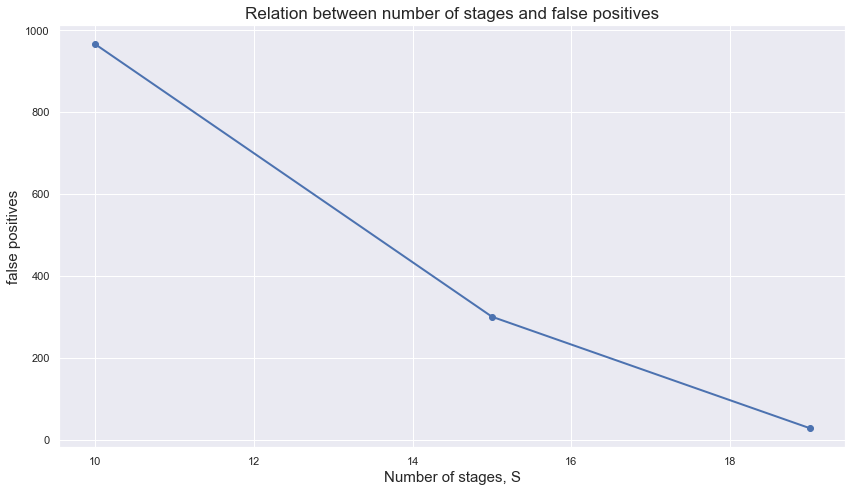

In [125]:
plt.figure(figsize = (12,7))
plt.grid('True')
plt.plot([10,15,19],[cf_10stages[2], cf_15stages[2], cf_19stages[2]],lw=2, marker = 'o')
plt.xlabel('Number of stages, S', fontsize = 15)
plt.ylabel('false positives', fontsize = 15)
plt.title('Relation between number of stages and false positives', fontsize = 17)
plt.tight_layout()
plt.show() 

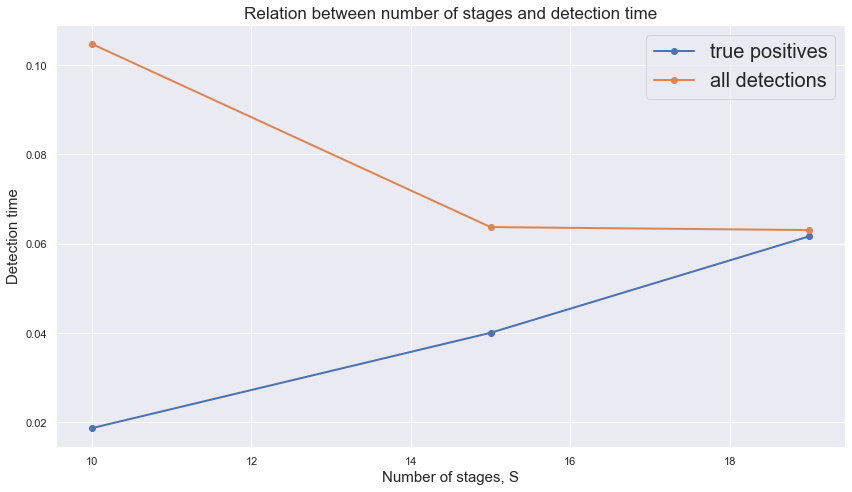

In [126]:
plt.figure(figsize = (12,7))
plt.grid('True')
plt.plot([10,15,19],[time_10stages[0], time_15stages[0], time_19stages[0]], lw=2, marker = 'o',label = 'true positives')
plt.plot([10,15,19], [time_10stages[1], time_15stages[1], time_19stages[1]],lw=2, marker = 'o', label = 'all detections')
plt.xlabel('Number of stages, S', fontsize = 15)
plt.ylabel('Detection time', fontsize = 15)
plt.title('Relation between number of stages and detection time', fontsize = 17)
plt.legend(loc="best",  prop={'size': 20})
plt.tight_layout()
plt.show() 

In [209]:
#false_positives_image_directory = r'C:\Users\FilSo\PycharmProjects\Master Thesis\false_positives'
screenshots_directory = r'C:\Users\FilSo\PycharmProjects\Master Thesis\screenshots_selected'
screenshots_directory_processed = r"C:\Users\FilSo\PycharmProjects\Master Thesis\screenshots_processed"
def reshape_imge_from_video(directory = screenshots_directory, processed_directory = screenshots_directory_processed, shape = (400,400)):
    list_im = []
    for position in os.listdir(directory):
        print(position)
        img_name = position
        img_path = os.path.join(directory, img_name)
        image = cv2.imread(img_path)

        #resize images for given shape
        down_points = shape
        image = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
        
        #save directory
        false_postive_with_rectangle_dir = processed_directory + '\Image' + str(position) + '.jpg'
        cv2.imwrite(false_postive_with_rectangle_dir, image)
        list_im.append(false_postive_with_rectangle_dir)
    return list_im

## Back projection visualizations

In [210]:
screenshots_list = reshape_imge_from_video()

dst528.jpg
dst536.jpg
dst544.jpg
dst553.jpg
dst797.jpg
dst801.jpg
dst805.jpg
dst810.jpg


In [211]:
def plot_frames_side_by_side(image_list: list, shape = (400,400), row_length = 4):
    
    rows = 2
    columns = 1
    first_row = resize_image_set(image_list[:row_length], shape)
    second_row = resize_image_set(image_list[row_length:], shape)
    fig = plt.figure(figsize=(15, 7))
    fig.subplots_adjust(hspace=0.0)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(first_row)
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(second_row)
    plt.axis('off')

C:\Users\FilSo\anaconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


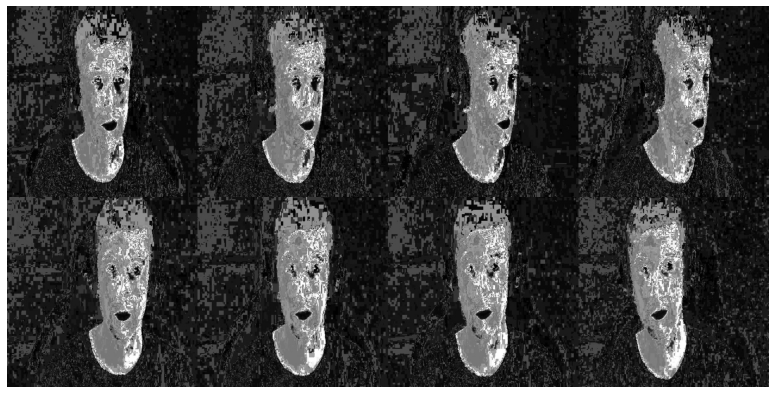

In [212]:
plot_frames_side_by_side(screenshots_list)